In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import glob
import os
from argparse import ArgumentParser
from PIL import Image
from torchvision.transforms import functional as F
from tqdm import tqdm
from utilities.print_utils import *
from transforms.classification.data_transforms import MEAN, STD
from utilities.utils import model_parameters, compute_flops


In [4]:
import importlib
import jn_test_segment
importlib.reload(jn_test_segment)

<module 'jn_test_segment' from '/home/john/github/EdgeNets/jn_test_segment.py'>

In [5]:
# in_args = "--model espnetv2 --s 2.0 --dataset city --data-path /home/john/github/data/cityscapes/ --split val --im-size 1024 512"
# 
# args = jn_test_segment.load_args(in_args)
in_args = " --dir /home/john/github/EdgeNets/ \
            --model espnetv2 --s 2.0  \
            --dataset city  \
            --data-path /home/john/github/data/cityscapes/  \
            --split val  \
            --im-size 1024 512 \
            --num-classes 20 \
        "
          # --weights-test /home/john/github/EdgeNets/model/segmentation/model_zoo/espnetv2/espnetv2_s_2.0_city_1024x512.pth \
          # "

args = jn_test_segment.load_args(in_args)


In [9]:
model, device = jn_test_segment.load_model(args)


2019-09-04 22:23:29 - WARNING - Training from scratch!!
2019-09-04 22:23:31 - INFO    - FLOPs for an input of size 1024x512: 2699.05 million
2019-09-04 22:23:31 - INFO    - # of parameters: 0.789242
2019-09-04 22:23:31 - INFO    - Loading model weights
2019-09-04 22:27:20 - INFO    - Weight loaded successfully


In [21]:
from torchsummary import summary
summary(model, (3, 512, 512),  device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
             PReLU-3         [-1, 32, 256, 256]              32
               CBR-4         [-1, 32, 256, 256]               0
         AvgPool2d-5         [-1, 32, 128, 128]               0
            Conv2d-6         [-1, 24, 256, 256]             192
       BatchNorm2d-7         [-1, 24, 256, 256]              48
             PReLU-8         [-1, 24, 256, 256]              24
               CBR-9         [-1, 24, 256, 256]               0
           Conv2d-10         [-1, 24, 128, 128]             216
         CDilated-11         [-1, 24, 128, 128]               0
           Conv2d-12         [-1, 24, 128, 128]             216
         CDilated-13         [-1, 24, 128, 128]               0
           Conv2d-14         [-1, 24, 1

In [5]:
from fastai import *
from fastai.vision import *

In [6]:
torch.cuda.is_available()


True

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
defaults.device = device
print(device)

path_lbl = Path('/home/john/github/techion-expts/unet/data/sim-unet/labels/')
path_img = Path('/home/john/github/techion-expts/unet/data/sim-unet/images/')

codes = np.array(['background', 'triangle', 'circle1', 'circle2', 'square_f', 'plus', 
                  '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19'])

get_label_fn = lambda x: path_lbl/f'{x.stem}.png'

def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

cuda:0


array(['background', 'triangle', 'circle1', 'circle2', 'square_f', 'plus', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19'], dtype='<U10')

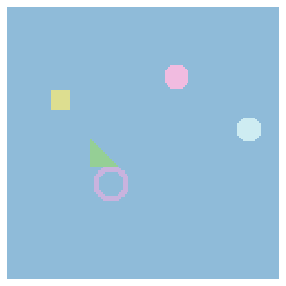

In [13]:
im = open_mask(f'{path_lbl}/img3.png')
# im.data.mul_(50)?
im.show(figsize=(5,5))
codes

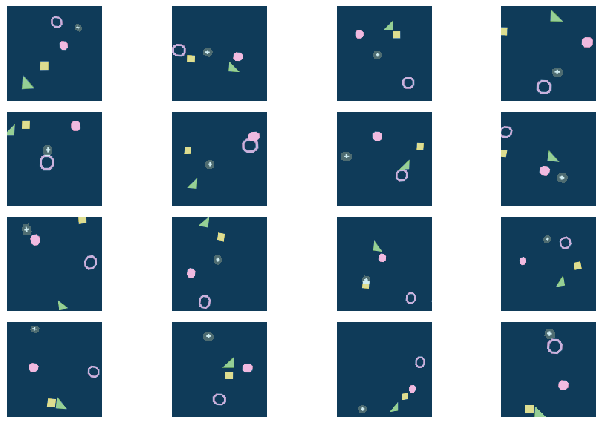

In [8]:
bs=16
size=128
codes = np.array(['background', 'triangle', 'circle1', 'circle2', 'square_f', 'plus'])

get_label_fn = lambda x: f'{path_lbl}/{x.stem}.png'
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(valid_pct=0.2, seed=42)
       .label_from_func(get_label_fn, classes=codes))

data = (src.transform(get_transforms(),  tfm_y=True, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
data.show_batch(4, figsize=(10,6))

In [121]:
## uses torch.nn.CrossEntropyLoss(...)    as a super class  
# class myLoss2(nn.BCEWithLogitsLoss):    
#     def __init__(self, weight=None):
#         super(myLoss2, self).__init__()
# 
#     def forward(self, input, target):
#         # import pdb; pdb.set_trace()
#         arginput = input.max(1)[1]
#         arginput = torch.unsqueeze(arginput, 1).float()
#         target = target.float()
#         ret = super(myLoss2, self).forward(arginput, target)
#         return ret
# loss_func = myLoss2() 
# def acc_camvid(input, target):
# #     target = target.float()
#         input = (input >0.5).long()
#         return (input==target).float().mean()
# lr=1e-4
# learn = Learner(data, model, loss_func = loss_func, metrics = acc_camvid)
# learn.lr_find()

In [9]:
def acc_metric1(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def acc_metric2(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()
  
metrics=[acc_metric1, acc_metric2]
## uses torch.nn.CrossEntropyLoss(...)    as a super class  
class myLoss2(nn.CrossEntropyLoss):    
    def __init__(self, weight=None):
        super(myLoss2, self).__init__()

    def forward(self, input, target):
        target = target.squeeze()
        ret = super(myLoss2, self).forward(input, target)
        return ret
    
weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0] # weight forground at 1/10
class_weights = torch.FloatTensor(weights)       

loss_func = myLoss2(weight=class_weights) 

learn = Learner(data, model, loss_func = loss_func, metrics = metrics)

In [48]:
learn.lr_find(start_lr=1e-3)

RuntimeError: cuda runtime error (4) : unspecified launch failure at /pytorch/torch/csrc/generic/serialization.cpp:23

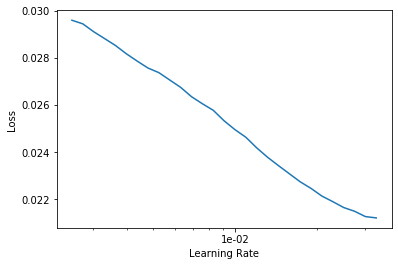

In [43]:
learn.recorder.plot()

In [23]:

lr=3e-3
learn.fit_one_cycle(40, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_metric1,acc_metric2,time
0,0.061746,0.049006,0.988312,0.671336,00:01
1,0.062765,0.047025,0.989487,0.714357,00:01
2,0.064303,0.046035,0.990280,0.742871,00:01
3,0.063935,0.045530,0.990906,0.768884,00:01
4,0.064153,0.045187,0.991150,0.780390,00:01
5,0.063815,0.044924,0.991272,0.787394,00:01
6,0.063721,0.044815,0.991440,0.793897,00:01
7,0.063607,0.044796,0.991531,0.799900,00:01
8,0.063547,0.044591,0.991516,0.803402,00:01
9,0.063210,0.044491,0.991486,0.804402,00:01


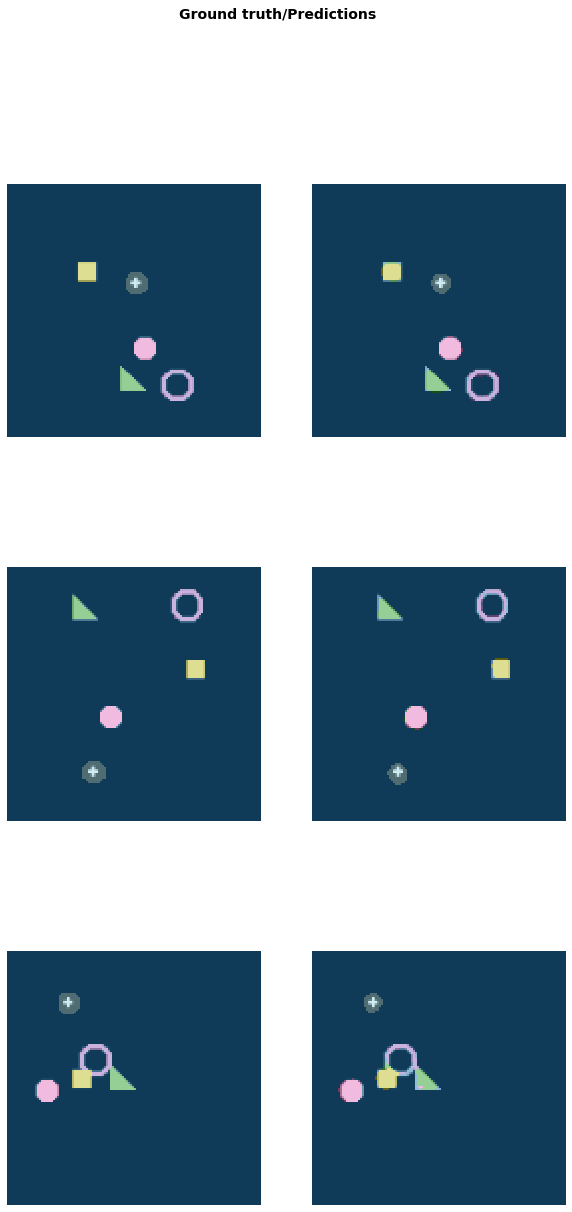

In [24]:
learn.show_results(rows=3, figsize=(10,20))

  